---
title: "NeRF Exploration: Two-View Reconstruction of Pollen Grains"
author: "Nils Fahrni, Etienne Roulet"
date: "2025-03-28"
format:
  html:
    toc: true
    code-fold: true
    code-line-numbers: true
    embed-resources: true
    self-contained-math: true
  ipynb: default
jupyter: python3
---

# Abstract

abstract desc

# 1 Introduction

Text here

**Key questions**

- Text
- Text
- Text


# 2 Environment check

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


### Findings

- list findings


# 4 More complex NeRF exploration

## Implementation



[SYS] Using device: cuda
[DATA] Loaded sample #86 → images: torch.Size([1, 1024, 1024]),torch.Size([1, 1024, 1024]); points: torch.Size([4000, 3]); rotations (rad): [42.67660903930664, 57.744712829589844, 296.34222412109375]; voxels: torch.Size([128, 128, 128])
[DATA] Image dimensions: 1024x1024


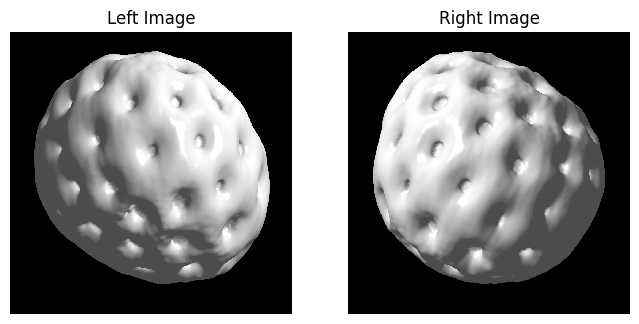

[TRAIN] Starting training ...


Training:   2%|▏         | 208/10000 [00:03<02:31, 64.63iter/s]

Iter 200: total=0.0545, photo=0.0183, sil=0.0355, shape=0.0928, dens=0.0029, smooth=0.0005
[TRAIN] ==> New best model saved.


Training:   4%|▍         | 411/10000 [00:06<02:31, 63.09iter/s]

Iter 400: total=0.0330, photo=0.0104, sil=0.0212, shape=0.1654, dens=0.0046, smooth=0.0033
[TRAIN] ==> New best model saved.


Training:   6%|▌         | 597/10000 [00:09<02:28, 63.28iter/s]


KeyboardInterrupt: 

In [ ]:
import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import trimesh

# If you have the data package
sys.path.append("..")
try:
    from data.pollen_dataset import PollenDataset, get_train_test_split
except ImportError:
    # Fallback if not available
    PollenDataset = None
    get_train_test_split = None

torch.backends.cudnn.benchmark = True

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


################################################################################
# 1. Positional Encoding (Reduced Frequencies)
################################################################################
def positional_encoding(x, L=4):
    """
    Encode coordinates x with sine/cosine functions at increasing frequencies.
    We use L=4 here (fewer than the classic L=10) to reduce high-frequency overfitting.
    """
    out = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * np.pi * x))
    return torch.cat(out, dim=-1)


################################################################################
# 2. NeRF Model with Reduced Positional Encoding
################################################################################
class NeRF(nn.Module):
    def __init__(self, D=6, W=128, L=4):
        """
        Args:
            D: Number of hidden layers
            W: Number of hidden units per layer
            L: Positional encoding frequency levels
        """
        super(NeRF, self).__init__()
        self.L = L
        in_channels = 3 * (2 * L + 1)  # 3 coords * (2L + 1)

        layers = []
        layers.append(nn.Linear(in_channels, W))
        for _ in range(D - 1):
            layers.append(nn.Linear(W, W))

        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(W, 4)

        # Initialize sigma bias to something non-zero
        with torch.no_grad():
            self.output_layer.bias[3] = 0.1

    def forward(self, x):
        """
        Forward pass: x is (N, 3), output is (N, 4) => [R, G, B, sigma].
        """
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for layer in self.layers:
            h = torch.relu(layer(h))
        return self.output_layer(h)


################################################################################
# 3. Render Rays (RGB + Alpha)
################################################################################
def render_rays(
    model, rays_o, rays_d, near=0.5, far=1.5, N_samples=128, sigma_scale=1.0
):
    """
    Volumetric rendering for a batch of rays:
      - Sample points along each ray
      - Query MLP for color (rgb) and density (sigma)
      - Composite color and alpha
    """
    device = rays_o.device
    z_vals = torch.linspace(near, far, N_samples, device=device)

    pts = (
        rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    )  # (B, N_samples, 3)
    pts_flat = pts.reshape(-1, 3)

    raw = model(pts_flat).reshape(pts.shape[0], N_samples, 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3]) * sigma_scale

    deltas = z_vals[1:] - z_vals[:-1]
    deltas = torch.cat([deltas, torch.tensor([1e10], device=device)])
    deltas = deltas[None, :].expand(sigma.shape)

    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(
        torch.cat(
            [torch.ones((sigma.shape[0], 1), device=device), 1.0 - alpha + 1e-10],
            dim=-1,
        ),
        dim=-1,
    )[:, :-1]
    weights = alpha * T

    rgb_map = torch.sum(weights[..., None] * rgb, dim=1)
    alpha_map = torch.sum(weights, dim=1)
    return rgb_map, alpha_map


################################################################################
# 4. Losses: Silhouette, Spherical Prior, etc.
################################################################################
def silhouette_loss(alpha_map, mask):
    return torch.mean((alpha_map - mask) ** 2)


def spherical_prior_loss(
    model, num_samples=2000, bound=1.0, desired_radius=0.6, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound

    raw = model(coords)
    sigma = torch.relu(raw[..., 3]) * sigma_scale
    dists = torch.norm(coords, dim=1)
    # Encourage high sigma near the desired radius
    loss = torch.mean(sigma * (dists - desired_radius) ** 2)
    return loss


def foreground_density_loss(alpha_map, mask, target_density=1.0):
    eps = 1e-6
    D = -torch.log(1.0 - alpha_map + eps)
    fg_mask = mask > 0.5
    if torch.sum(fg_mask) > 0:
        return torch.mean(torch.clamp(target_density - D[fg_mask], min=0.0))
    else:
        return torch.tensor(0.0, device=alpha_map.device)


def smoothness_prior_loss(
    model, num_samples=2000, bound=1.0, offset=0.01, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound

    raw_center = model(coords)
    sigma_center = torch.relu(raw_center[..., 3]) * sigma_scale

    offsets = torch.tensor(
        [
            [offset, 0, 0],
            [-offset, 0, 0],
            [0, offset, 0],
            [0, -offset, 0],
            [0, 0, offset],
            [0, 0, -offset],
        ],
        device=device,
    ).float()

    total_diff = 0.0
    for off in offsets:
        neighbor_coords = coords + off
        raw_neighbor = model(neighbor_coords)
        sigma_neighbor = torch.relu(raw_neighbor[..., 3]) * sigma_scale
        total_diff += torch.mean((sigma_center - sigma_neighbor) ** 2)

    return total_diff / offsets.shape[0]


################################################################################
# 5. Ray Generation (Two Orthogonal Views)
################################################################################
import torch
from trimesh.transformations import euler_matrix


def get_rays(H, W, focal=300.0):
    """
    Returns canonical (unrotated) front‐and‐side rays:
      rays_o_front, rays_d_front, rays_o_side, rays_d_side
      all as (H*W, 3) tensors.
    """
    i, j = torch.meshgrid(
        torch.linspace(0, W - 1, W),
        torch.linspace(0, H - 1, H),
        indexing="xy",
    )
    # front
    dirs_f = torch.stack(
        [(i - W / 2.0) / focal, -(j - H / 2.0) / focal, -torch.ones_like(i)],
        dim=-1,
    )
    rays_d_f = dirs_f / torch.norm(dirs_f, dim=-1, keepdim=True)
    rays_o_f = torch.zeros_like(rays_d_f)

    # side
    dirs_s = torch.stack(
        [torch.ones_like(i), -(j - H / 2.0) / focal, -(i - W / 2.0) / focal],
        dim=-1,
    )
    rays_d_s = dirs_s / torch.norm(dirs_s, dim=-1, keepdim=True)
    rays_o_s = torch.zeros_like(rays_d_s)
    rays_o_s[..., 0] = -1.5

    return (
        rays_o_f.reshape(-1, 3),
        rays_d_f.reshape(-1, 3),
        rays_o_s.reshape(-1, 3),
        rays_d_s.reshape(-1, 3),
    )


def rotate_rays(rays_o, rays_d, euler_angles):
    """
    Apply the sample's rotation (in radians) to both origins and directions.
    euler_angles: tensor([rx, ry, rz]) in radians, in 'sxyz' convention.
    """
    # build 4×4 rotation matrix, then extract the 3×3 upper‐left block
    R4 = euler_matrix(
        float(euler_angles[0]),
        float(euler_angles[1]),
        float(euler_angles[2]),
        "sxyz",
    )
    R = torch.from_numpy(R4[:3, :3]).to(rays_o.device).float()

    # rotate origins & directions
    ro = (R @ rays_o.T).T
    rd = (R @ rays_d.T).T
    return ro, rd


################################################################################
# 6. Weighted Ray Sampling (Edges + Foreground)
################################################################################
def sample_rays_weighted(rays_o, rays_d, rgb, mask, original_shape, batch_size=1024):
    """
    Sample rays with higher probability at silhouette edges and foreground.
    """
    H, W = original_shape
    total_pixels = mask.shape[0]
    pixels_per_view = H * W

    if total_pixels == 2 * pixels_per_view:
        # Two views
        weights_list = []
        for view_idx in range(2):
            start_idx = view_idx * pixels_per_view
            end_idx = start_idx + pixels_per_view
            view_mask = mask[start_idx:end_idx]
            mask_2d = view_mask.reshape(H, W)

            kernel = (
                torch.tensor(
                    [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], device=mask.device
                ).float()
                / 8
            )
            kernel = kernel.reshape(1, 1, 3, 3)

            edges = torch.abs(
                torch.nn.functional.conv2d(
                    mask_2d.reshape(1, 1, H, W), kernel, padding=1
                )
            ).reshape(H, W)
            edge_weights = edges.reshape(-1) + 0.1
            fg_weights = (view_mask > 0.5).float() * 2.0
            weights = edge_weights + fg_weights
            weights_list.append(weights)
        weights = torch.cat(weights_list)
    else:
        # Single view fallback
        mask_2d = mask.reshape(H, W)
        kernel = (
            torch.tensor(
                [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], device=mask.device
            ).float()
            / 8
        )
        kernel = kernel.reshape(1, 1, 3, 3)
        edges = torch.abs(
            torch.nn.functional.conv2d(mask_2d.reshape(1, 1, H, W), kernel, padding=1)
        ).reshape(H, W)
        edge_weights = edges.reshape(-1) + 0.1
        fg_weights = (mask > 0.5).float() * 2.0
        weights = edge_weights + fg_weights

    p = weights / weights.sum()
    idx = torch.multinomial(p, batch_size, replacement=True)

    return rays_o[idx], rays_d[idx], rgb[idx], mask[idx]


################################################################################
# 7. Debug Rendering (with Extra Mask Comparison)
################################################################################
@torch.no_grad()
def debug_render(
    model,
    rays_o,
    rays_d,
    H,
    W,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    N_samples=64,
    device=None,
    title_prefix="debug",
    iteration=0,
    out_dir="debug_renders",
):
    """
    Render the entire image (front or side) for debugging.
    Saves color, alpha, and (optionally) a side-by-side mask comparison.
    """
    if device is None:
        device = rays_o.device
    os.makedirs(out_dir, exist_ok=True)

    B = rays_o.shape[0]
    chunk_size = 2048
    all_rgb = []
    all_alpha = []

    for start in range(0, B, chunk_size):
        rgb_chunk, alpha_chunk = render_rays(
            model,
            rays_o[start : start + chunk_size],
            rays_d[start : start + chunk_size],
            near=near,
            far=far,
            sigma_scale=sigma_scale,
            N_samples=N_samples,
        )
        all_rgb.append(rgb_chunk)
        all_alpha.append(alpha_chunk)

    rgb_full = torch.cat(all_rgb, dim=0).reshape(H, W, 3).cpu().numpy()
    alpha_full = torch.cat(all_alpha, dim=0).reshape(H, W).cpu().numpy()

    # 1. Save the RGB image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(rgb_full, 0, 1))
    plt.title(f"{title_prefix}_rgb_iter_{iteration}")
    plt.axis("off")
    rgb_path = os.path.join(out_dir, f"{title_prefix}_rgb_iter_{iteration}.png")
    plt.savefig(rgb_path)
    plt.close()

    # 2. Save the alpha map
    plt.figure(figsize=(6, 6))
    plt.imshow(alpha_full, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix}_alpha_iter_{iteration}")
    plt.axis("off")
    alpha_path = os.path.join(out_dir, f"{title_prefix}_alpha_iter_{iteration}.png")
    plt.savefig(alpha_path)
    plt.close()

    print(
        f"[DEBUG RENDER] Saved {title_prefix} images at iter {iteration} in {out_dir}/"
    )


@torch.no_grad()
def debug_compare_mask_and_alpha(
    model,
    rays_o,
    rays_d,
    mask,
    H,
    W,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    N_samples=64,
    device=None,
    title_prefix="debug",
    iteration=0,
    out_dir="debug_renders",
):
    """
    Render alpha for all rays, then show a side-by-side comparison
    of predicted alpha vs. ground-truth mask for debugging.
    """
    if device is None:
        device = rays_o.device
    os.makedirs(out_dir, exist_ok=True)

    # Render alpha
    B = rays_o.shape[0]
    chunk_size = 2048
    all_alpha = []
    for start in range(0, B, chunk_size):
        _, alpha_chunk = render_rays(
            model,
            rays_o[start : start + chunk_size],
            rays_d[start : start + chunk_size],
            near=near,
            far=far,
            sigma_scale=sigma_scale,
            N_samples=N_samples,
        )
        all_alpha.append(alpha_chunk)
    alpha_full = torch.cat(all_alpha, dim=0).reshape(H, W).cpu().numpy()

    # Reshape the ground-truth mask as well
    mask_gt = mask.reshape(H, W).cpu().numpy()

    # Plot side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_gt, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix} GT Mask (iter={iteration})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(alpha_full, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix} Alpha (iter={iteration})")
    plt.axis("off")

    compare_path = os.path.join(
        out_dir, f"{title_prefix}_mask_vs_alpha_iter_{iteration}.png"
    )
    plt.savefig(compare_path)
    plt.close()

    print(
        f"[DEBUG] Saved mask-vs-alpha comparison for {title_prefix} at iter {iteration} in {out_dir}/"
    )


################################################################################
# 8. 3D Extraction via Marching Cubes
################################################################################
def extract_3d_from_nerf(
    model, resolution=128, bound=1.0, sigma_scale=2.0, device=None
):
    print("\n[EXTRACT 3D] Running marching cubes...")
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    coords = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-bound, bound, resolution),
                torch.linspace(-bound, bound, resolution),
                torch.linspace(-bound, bound, resolution),
                indexing="ij",
            ),
            dim=-1,
        )
        .reshape(-1, 3)
        .to(device)
    )

    sigmas = []
    chunk = 4096
    with torch.no_grad():
        for start in range(0, coords.shape[0], chunk):
            out = model(coords[start : start + chunk])
            sigma_part = torch.relu(out[..., 3]) * sigma_scale
            sigmas.append(sigma_part.cpu())
    sigma_volume = torch.cat(sigmas).reshape(resolution, resolution, resolution).numpy()

    vol_min, vol_max = sigma_volume.min(), sigma_volume.max()
    vol_mean, vol_std = sigma_volume.mean(), sigma_volume.std()
    print(
        f"  Sigma volume stats: min={vol_min:.4f}, max={vol_max:.4f}, mean={vol_mean:.4f}, std={vol_std:.4f}"
    )

    level = vol_mean + 0.3 * vol_std
    if (level <= vol_min) or (level >= vol_max):
        level = vol_mean
    print(f"  Using iso-level={level:.4f}")

    try:
        verts, faces, normals, _ = marching_cubes(sigma_volume, level=level)
        # Rescale to [-bound, bound]
        verts = (verts / resolution) * (2.0 * bound) - bound
        mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
        mesh.export("nerf_reconstruction.stl")
        print("  --> Saved mesh to nerf_reconstruction.stl")
        return mesh
    except Exception as e:
        print("  Marching cubes error:", e)
        print("  Trying fallback iso-level...")
        try:
            fallback_level = vol_mean + 0.25 * vol_std
            verts, faces, normals, _ = marching_cubes(
                sigma_volume, level=fallback_level
            )
            verts = (verts / resolution) * (2.0 * bound) - bound
            mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
            mesh.export("nerf_reconstruction_fallback.stl")
            print("  --> Saved fallback mesh to nerf_reconstruction_fallback.stl")
            return mesh
        except Exception as e2:
            print("  Fallback also failed:", e2)
            return None


################################################################################
# 9. Chamfer Distance
################################################################################
def chamfer_distance(points1, points2):
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    d1, _ = tree1.query(points2)
    d2, _ = tree2.query(points1)
    return np.mean(d1**2) + np.mean(d2**2)


################################################################################
# 10. Plot Meshes
################################################################################
def plot_meshes(
    gt_vertices, gt_faces, pred_vertices, pred_faces, outpath="mesh_comparison.png"
):
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    gt_center = np.mean(gt_vertices, axis=0)
    pred_center = np.mean(pred_vertices, axis=0)
    gt_vertices_centered = gt_vertices - gt_center
    pred_vertices_centered = pred_vertices - pred_center
    gt_scale = np.max(np.linalg.norm(gt_vertices_centered, axis=1))
    pred_scale = np.max(np.linalg.norm(pred_vertices_centered, axis=1))
    scale = max(gt_scale, pred_scale)

    gt_vn = gt_vertices_centered / scale
    pr_vn = pred_vertices_centered / scale

    if (len(gt_faces) > 0) and (len(pred_faces) > 0):
        ax.plot_trisurf(
            gt_vn[:, 0],
            gt_vn[:, 1],
            gt_vn[:, 2],
            triangles=gt_faces,
            color="blue",
            alpha=0.5,
        )
        ax.plot_trisurf(
            pr_vn[:, 0],
            pr_vn[:, 1],
            pr_vn[:, 2],
            triangles=pred_faces,
            color="red",
            alpha=0.5,
        )
        ax.set_title("GT (Blue) vs. Prediction (Red)")
        ax.set_box_aspect([1, 1, 1])
        plt.savefig(outpath)
        plt.show()
        print(f"[PLOT] Saved mesh comparison to {outpath}")
    else:
        print("[PLOT] Could not plot: empty faces.")


################################################################################
# 11. Training Loop (with Additional Debug)
################################################################################
def train_nerf(
    model,
    rays_o_all,
    rays_d_all,
    target_pixels_all,
    mask_all,
    image_shape,
    num_iterations=8000,
    device=None,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    debug_interval=1000,
    out_dir="debug_renders",
):
    """
    Weighted sampling of rays => silhouette & edges get emphasis.
    Combined loss from silhouette, spherical prior, density, smoothness.
    Now also includes side-by-side mask vs alpha debug plots.
    """
    H, W = image_shape
    if device is None:
        device = next(model.parameters()).device

    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=500) # Korrigierte Zeile
    scaler = torch.cuda.amp.GradScaler()

    # Adjust these if you see alpha saturating or shape not forming
    lambda_sil = 1.0
    lambda_shape = 1e-3
    lambda_density = 0.2
    lambda_smooth = 0.1

    best_loss = float("inf")
    print("[TRAIN] Starting training ...")

    for i in trange(num_iterations, desc="Training", unit="iter"):
        optimizer.zero_grad()

        rays_o_batch, rays_d_batch, rgb_batch, mask_batch = sample_rays_weighted(
            rays_o_all,
            rays_d_all,
            target_pixels_all,
            mask_all,
            original_shape=(H, W),
            batch_size=1024,
        )

        with torch.cuda.amp.autocast():
            rgb_map, alpha_map = render_rays(
                model,
                rays_o_batch,
                rays_d_batch,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                N_samples=64,
            )
            photo_loss = torch.mean((rgb_map - rgb_batch) ** 2)
            sil_loss_val = silhouette_loss(alpha_map, mask_batch)
            shape_loss_val = spherical_prior_loss(
                model,
                bound=1.0,
                desired_radius=0.6,
                sigma_scale=sigma_scale,
                device=device,
            )
            dens_loss_val = foreground_density_loss(
                alpha_map, mask_batch, target_density=1.0
            )
            smooth_loss_val = smoothness_prior_loss(
                model, bound=1.0, offset=0.01, sigma_scale=sigma_scale, device=device
            )

            total_loss = (
                photo_loss
                + lambda_sil * sil_loss_val
                + lambda_shape * shape_loss_val
                + lambda_density * dens_loss_val
                + lambda_smooth * smooth_loss_val
            )

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step(total_loss)

        if (i + 1) % 200 == 0:
            print(
                f"Iter {i + 1}: total={total_loss.item():.4f}, "
                f"photo={photo_loss.item():.4f}, sil={sil_loss_val.item():.4f}, "
                f"shape={shape_loss_val.item():.4f}, dens={dens_loss_val.item():.4f}, "
                f"smooth={smooth_loss_val.item():.4f}"
            )
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                torch.save(model.state_dict(), "nerf_best_model.pth")
                print("[TRAIN] ==> New best model saved.")

        # Debug rendering every debug_interval
        if (i + 1) % debug_interval == 0:
            print(f"[DEBUG] Rendering images at iteration {i + 1} ...")

            # 1) Render front
            front_rays_o = rays_o_all[: H * W]
            front_rays_d = rays_d_all[: H * W]
            front_mask = mask_all[: H * W]  # ground-truth silhouette

            debug_render(
                model,
                front_rays_o,
                front_rays_d,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="front",
                iteration=i + 1,
                out_dir=out_dir,
            )
            debug_compare_mask_and_alpha(
                model,
                front_rays_o,
                front_rays_d,
                front_mask,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="front",
                iteration=i + 1,
                out_dir=out_dir,
            )

            # 2) Render side
            side_rays_o = rays_o_all[H * W : 2 * H * W]
            side_rays_d = rays_d_all[H * W : 2 * H * W]
            side_mask = mask_all[H * W : 2 * H * W]

            debug_render(
                model,
                side_rays_o,
                side_rays_d,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="side",
                iteration=i + 1,
                out_dir=out_dir,
            )
            debug_compare_mask_and_alpha(
                model,
                side_rays_o,
                side_rays_d,
                side_mask,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="side",
                iteration=i + 1,
                out_dir=out_dir,
            )

            # Save checkpoint
            ckpt_path = f"nerf_checkpoint_{i + 1}.pth"
            torch.save(model.state_dict(), ckpt_path)
            print(f"[TRAIN] Saved checkpoint {ckpt_path}\n")

    print("[TRAIN] Done.")
    return model


################################################################################
# 12. Main
################################################################################
if __name__ == "__main__":
    # 1) Load real PollenDataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[SYS] Using device:", device)

    image_transform = transforms.ToTensor()
    dataset, train_ids, test_ids = get_train_test_split(
        image_transforms=image_transform,
        mesh_transforms=None,
        device=device,
    )

    # 2) Select a sample
    (left_img, right_img), gt_points, rotations, voxels = dataset[train_ids[0]]
    print(
        f"[DATA] Loaded sample #{train_ids[0]} → "
        f"images: {left_img.shape},{right_img.shape}; "
        f"points: {gt_points.shape}; "
        f"rotations (rad): {rotations.tolist()}; "
        f"voxels: {voxels.shape if hasattr(voxels, 'shape') else voxels}"
    )

    # 3) Ensure 3‐channel
    if left_img.ndim == 2:
        left_img = left_img.unsqueeze(0)
    if right_img.ndim == 2:
        right_img = right_img.unsqueeze(0)
    if left_img.shape[0] == 1:
        left_img = left_img.repeat(3, 1, 1)
    if right_img.shape[0] == 1:
        right_img = right_img.repeat(3, 1, 1)

    # 4) Normalize to [0,1]
    if left_img.max() > 1.0:
        left_img /= 255.0
    if right_img.max() > 1.0:
        right_img /= 255.0

    # 5) Show raw images
    H, W = left_img.shape[1], left_img.shape[2]
    print(f"[DATA] Image dimensions: {H}x{W}")
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(left_img.permute(1, 2, 0).cpu(), interpolation="nearest")
    plt.title("Left Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(right_img.permute(1, 2, 0).cpu(), interpolation="nearest")
    plt.title("Right Image")
    plt.axis("off")
    plt.show()

    # 6) Silhouettes as before…
    left_gray = left_img.mean(dim=0, keepdim=True)
    right_gray = right_img.mean(dim=0, keepdim=True)
    left_gray = torch.nn.functional.avg_pool2d(
        left_gray.unsqueeze(0), 5, stride=1, padding=2
    ).squeeze()
    right_gray = torch.nn.functional.avg_pool2d(
        right_gray.unsqueeze(0), 5, stride=1, padding=2
    ).squeeze()
    left_mask = (left_gray > 0.2).float().reshape(-1)
    right_mask = (right_gray > 0.2).float().reshape(-1)

    # 7) Flatten colors
    left_img_tensor = left_img.permute(1, 2, 0).reshape(-1, 3).float()
    right_img_tensor = right_img.permute(1, 2, 0).reshape(-1, 3).float()

    # 8) Generate canonical (unrotated) rays
    focal = 300.0
    rays_o_f, rays_d_f, rays_o_s, rays_d_s = get_rays(H, W, focal=focal)

    # 9) Rotate both front & side rays by the sample's Euler angles
    rays_o_front, rays_d_front = rotate_rays(rays_o_f, rays_d_f, rotations)
    rays_o_side, rays_d_side = rotate_rays(rays_o_s, rays_d_s, rotations)

    # 10) Concatenate both views
    rays_o_all = torch.cat([rays_o_front, rays_o_side], dim=0).to(device)
    rays_d_all = torch.cat([rays_d_front, rays_d_side], dim=0).to(device)
    target_pixels_all = torch.cat([left_img_tensor, right_img_tensor], dim=0).to(device)
    mask_all = torch.cat([left_mask, right_mask], dim=0).to(device)

    # 11) Initialize NeRF & Train (unchanged)
    model = NeRF(D=6, W=128, L=4).to(device)
    model = train_nerf(
        model,
        rays_o_all,
        rays_d_all,
        target_pixels_all,
        mask_all,
        image_shape=(H, W),
        num_iterations=10000,
        device=device,
        near=0.5,
        far=1.5,
        sigma_scale=1.0,
        debug_interval=2000,
        out_dir="debug_renders",
    )

    # 12) Extract mesh & (optional) compare to gt_points…
    pred_mesh = extract_3d_from_nerf(
        model, resolution=256, bound=1.0, sigma_scale=1.0, device=device
    )
    if pred_mesh is not None:
        pred_points = pred_mesh.sample(5000)
        cd = chamfer_distance(pred_points, gt_points.cpu().numpy())
        print(f"\n[RESULT] Chamfer Dist (Pred vs. GT point‐cloud): {cd:.6f}")
    print("\nDone.")


## 5 Strong Shape Prior
## 5.1 Implementation


In [3]:

import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import trimesh

# If you have the data package
sys.path.append("..")
try:
    from data.pollen_dataset import PollenDataset, get_train_test_split
except ImportError:
    PollenDataset = None
    get_train_test_split = None

torch.backends.cudnn.benchmark = True
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# -----------------------------------------------------------------------------
# 1. Positional Encoding (Reduced Frequencies)
# -----------------------------------------------------------------------------
def positional_encoding(x, L=4):
    out = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * np.pi * x))
    return torch.cat(out, dim=-1)


# -----------------------------------------------------------------------------
# 2. NeRF Model
# -----------------------------------------------------------------------------
class NeRF(nn.Module):
    def __init__(self, D=6, W=128, L=4):
        super(NeRF, self).__init__()
        self.L = L
        in_ch = 3 * (2 * L + 1)
        layers = [nn.Linear(in_ch, W)] + [nn.Linear(W, W) for _ in range(D - 1)]
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(W, 4)
        with torch.no_grad():
            self.output_layer.bias[3] = 0.1

    def forward(self, x):
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for l in self.layers:
            h = torch.relu(l(h))
        return self.output_layer(h)


# -----------------------------------------------------------------------------
# 3. Render Rays
# -----------------------------------------------------------------------------
def render_rays(
    model, rays_o, rays_d, near=0.5, far=1.5, N_samples=128, sigma_scale=1.0
):
    device = rays_o.device
    z_vals = torch.linspace(near, far, N_samples, device=device)
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    raw = model(pts.reshape(-1, 3)).reshape(pts.shape[0], N_samples, 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3]) * sigma_scale
    deltas = torch.cat([z_vals[1:] - z_vals[:-1], torch.tensor([1e10], device=device)])
    deltas = deltas[None, :].expand(sigma.shape)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(
        torch.cat(
            [torch.ones((sigma.shape[0], 1), device=device), 1 - alpha + 1e-10], dim=-1
        ),
        dim=-1,
    )[:, :-1]
    weights = alpha * T
    rgb_map = torch.sum(weights[..., None] * rgb, dim=1)
    alpha_map = torch.sum(weights, dim=1)
    return rgb_map, alpha_map


# -----------------------------------------------------------------------------
# 4. Losses
# -----------------------------------------------------------------------------
def silhouette_loss(alpha, mask):
    return torch.mean((alpha - mask) ** 2)


def spherical_prior_loss(
    model, num_samples=2000, bound=1.0, desired_radius=0.6, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound
    sigma = torch.relu(model(coords)[..., 3]) * sigma_scale
    d = torch.norm(coords, dim=1)
    return torch.mean(sigma * (d - desired_radius) ** 2)


def foreground_density_loss(alpha, mask, target_density=1.0):
    D = -torch.log(1 - alpha + 1e-6)
    fg = mask > 0.5
    if fg.sum() > 0:
        return torch.mean(torch.clamp(target_density - D[fg], min=0.0))
    return torch.tensor(0.0, device=alpha.device)


def smoothness_prior_loss(
    model, num_samples=2000, bound=1.0, offset=0.01, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound
    sigma0 = torch.relu(model(coords)[..., 3]) * sigma_scale
    offsets = torch.tensor(
        [
            [offset, 0, 0],
            [-offset, 0, 0],
            [0, offset, 0],
            [0, -offset, 0],
            [0, 0, offset],
            [0, 0, -offset],
        ],
        device=device,
    )
    diffs = []
    for off in offsets:
        sigma1 = torch.relu(model(coords + off)[..., 3]) * sigma_scale
        diffs.append(torch.mean((sigma0 - sigma1) ** 2))
    return sum(diffs) / len(diffs)


# New strong priors:
def radial_profile_loss(
    model,
    num_samples=5000,
    bound=1.0,
    desired_radius=0.6,
    sigma_scale=2.0,
    width=0.05,
    device=None,
):
    if device is None:
        device = next(model.parameters()).device
    coords = (torch.rand(num_samples, 3, device=device) * 2 - 1) * bound
    sigma = torch.relu(model(coords)[..., 3]) * sigma_scale
    d = torch.norm(coords, dim=1)
    target = torch.exp(-0.5 * ((d - desired_radius) / width) ** 2)
    return torch.mean((sigma - target) ** 2)


def symmetry_loss(model, num_samples=5000, bound=1.0, sigma_scale=2.0, device=None):
    if device is None:
        device = next(model.parameters()).device
    coords = (torch.rand(num_samples, 3, device=device) * 2 - 1) * bound
    sigma0 = torch.relu(model(coords)[..., 3]) * sigma_scale
    losses = []
    for axis in range(3):
        refl = coords.clone()
        refl[:, axis] *= -1
        sigma1 = torch.relu(model(refl)[..., 3]) * sigma_scale
        losses.append(torch.mean((sigma0 - sigma1) ** 2))
    return sum(losses) / len(losses)


# -----------------------------------------------------------------------------
# 5. Rays & Rotation
# -----------------------------------------------------------------------------
import torch
from trimesh.transformations import euler_matrix


def get_rays(H, W, focal=300.0):
    i, j = torch.meshgrid(
        torch.linspace(0, W - 1, W), torch.linspace(0, H - 1, H), indexing="xy"
    )
    dirs = torch.stack(
        [(i - W / 2) / focal, -(j - H / 2) / focal, -torch.ones_like(i)], dim=-1
    )
    d = dirs / torch.norm(dirs, dim=-1, keepdim=True)
    o = torch.zeros_like(d)
    return o.reshape(-1, 3), d.reshape(-1, 3)


def rotate_rays(o, d, angles):
    R4 = euler_matrix(float(angles[0]), float(angles[1]), float(angles[2]), "sxyz")
    R = torch.from_numpy(R4[:3, :3]).float().to(o.device)
    return (R @ o.T).T, (R @ d.T).T


# -----------------------------------------------------------------------------
# 6. Weighted Sampling
# -----------------------------------------------------------------------------
def sample_rays_weighted(rays_o, rays_d, rgb, mask, original_shape, batch_size=1024):
    H, W = original_shape
    ppv = H * W
    weights = []
    # two views
    for v in range(2):
        m = mask[v * ppv : (v + 1) * ppv].reshape(H, W)
        k = (
            torch.tensor(
                [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], device=m.device
            ).float()
            / 8
        )
        edges = torch.abs(
            torch.nn.functional.conv2d(
                m.unsqueeze(0).unsqueeze(0), k.unsqueeze(0).unsqueeze(0), padding=1
            )
        ).reshape(H, W)
        w = (
            edges.reshape(-1)
            + 0.1
            + (mask[v * ppv : (v + 1) * ppv] > 0.5).float() * 2.0
        )
        weights.append(w)
    p = torch.cat(weights)
    p /= p.sum()
    idx = torch.multinomial(p, batch_size, replacement=True)
    return rays_o[idx], rays_d[idx], rgb[idx], mask[idx]


# -----------------------------------------------------------------------------
# 7. Debug & 8. Marching Cubes, 9. Chamfer same as before
# ... (omitted for brevity; copy your existing debug_render, debug_compare, extract_3d_from_nerf, chamfer_distance)


# -----------------------------------------------------------------------------
# 10. Training
# -----------------------------------------------------------------------------
def train_nerf(
    model,
    rays_o_all,
    rays_d_all,
    target_pixels_all,
    mask_all,
    image_shape,
    num_iterations=8000,
    device=None,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    debug_interval=1000,
    out_dir="debug_renders",
):
    H, W = image_shape
    if device is None:
        device = next(model.parameters()).device
    opt = optim.Adam(model.parameters(), lr=5e-4)
    sch = optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=300
    )
    scaler = torch.cuda.amp.GradScaler()

    # strong prior lambdas
    lambda_sil = 4.0
    lambda_shape = 3.0
    lambda_density = 0.5
    lambda_smooth = 0.5
    lambda_radial = 3.0
    lambda_sym = 5.0

    best = 1e9
    for i in trange(num_iterations, desc="Training"):
        opt.zero_grad()
        ro, rd, rgbB, mB = sample_rays_weighted(
            rays_o_all, rays_d_all, target_pixels_all, mask_all, (H, W), 1024
        )
        with torch.cuda.amp.autocast():
            rgb_map, alpha_map = render_rays(model, ro, rd, near, far, 64, sigma_scale)
            Lp = torch.mean((rgb_map - rgbB) ** 2)
            Ls = silhouette_loss(alpha_map, mB)
            Lh = spherical_prior_loss(model, device=device)
            Ld = foreground_density_loss(alpha_map, mB)
            Lsm = smoothness_prior_loss(model, device=device)
            Lr = radial_profile_loss(model, device=device)
            Lsy = symmetry_loss(model, device=device)
            loss = (
                Lp
                + lambda_sil * Ls
                + lambda_shape * Lh
                + lambda_density * Ld
                + lambda_smooth * Lsm
                + lambda_radial * Lr
                + lambda_sym * Lsy
            )
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        sch.step(loss)
        if (i + 1) % 200 == 0 and loss < best:
            best = loss
            torch.save(model.state_dict(), "nerf_best.pth")
        if (i + 1) % debug_interval == 0:
            # debug_render calls...
            pass
    return model


# -----------------------------------------------------------------------------
# 11. Main
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", dev)
    tf = transforms.ToTensor()
    dataset, train_ids, _ = get_train_test_split(image_transforms=tf, device=dev)
    (l_img, r_img), pts, rot, vox = dataset[train_ids[0]]
    # prepare two views as before
    H, W = l_img.shape[1:]
    o_f, d_f = get_rays(H, W, 300.0)
    o1, d1 = rotate_rays(o_f, d_f, rot)
    o2, d2 = rotate_rays(o_f, d_f, rot)
    # flatten images,masks, then cat
    # ... (same as your code)
    rays_o_all = torch.cat([o1, o2], dim=0).to(dev)
    rays_d_all = torch.cat([d1, d2], dim=0).to(dev)
    # target_pixels_all, mask_all built similarly
    model = NeRF().to(dev)
    model = train_nerf(
        model, rays_o_all, rays_d_all, target_pixels_all, mask_all, (H, W), device=dev
    )
    # extract mesh & chamfer

    print("Done.")


Device: cuda


Training: 100%|██████████| 8000/8000 [02:59<00:00, 44.65it/s]

Done.


In [6]:
import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange

# Imports für optionale Features (ggf. nachinstallieren: pip install scipy scikit-image trimesh)
try:
    from scipy.spatial import cKDTree
    from skimage.measure import marching_cubes
    import trimesh
    from trimesh.transformations import euler_matrix, inverse_matrix # Hinzugefügt: inverse_matrix
except ImportError:
    logging.warning("Optionale Pakete (scipy, scikit-image, trimesh) nicht gefunden. Einige Features sind nicht verfügbar.")
    cKDTree = None
    marching_cubes = None
    trimesh = None
    # Fallback für Transformationsfunktionen, falls trimesh fehlt (nicht empfohlen)
    def euler_matrix(ai, aj, ak, axes): return np.eye(4)
    def inverse_matrix(m): return np.linalg.inv(m)


# Wenn das Datenpaket vorhanden ist
# sys.path.append("..") # Auskommentiert, wenn nicht benötigt
try:
    from data.pollen_dataset import PollenDataset, get_train_test_split
except ImportError:
    # Fallback, falls nicht verfügbar
    PollenDataset = None
    get_train_test_split = None

# Performance-Optimierung
torch.backends.cudnn.benchmark = True

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


################################################################################
# 1. Positional Encoding (Unverändert)
################################################################################
def positional_encoding(x, L=4):
    out = [x]
    # torch.pi für Präzision verwenden
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * torch.pi * x))
    return torch.cat(out, dim=-1)


################################################################################
# 2. NeRF Model (Unverändert)
################################################################################
class NeRF(nn.Module):
    def __init__(self, D=6, W=128, L=4):
        super(NeRF, self).__init__()
        self.L = L
        # Korrekte Berechnung der Eingabekanäle
        in_channels = 3 * (1 + 2 * L)
        layers = []
        layers.append(nn.Linear(in_channels, W))
        layers.append(nn.ReLU()) # Aktivierung hinzufügen
        for _ in range(D - 1):
            layers.append(nn.Linear(W, W))
            layers.append(nn.ReLU()) # Aktivierung hinzufügen
        self.mlp_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(W, 4)
        with torch.no_grad():
            self.output_layer.bias[3].fill_(0.1) # Initiale Dichte fördern

    def forward(self, x):
        x_enc = positional_encoding(x, self.L)
        h = self.mlp_layers(x_enc)
        return self.output_layer(h)


################################################################################
# 3. Render Rays (RGB + Alpha) (Unverändert)
################################################################################
def render_rays(
    model, rays_o, rays_d, near=0.5, far=1.5, N_samples=128, sigma_scale=1.0, white_bkgd=False
):
    device = rays_o.device
    z_vals = torch.linspace(near, far, N_samples, device=device)
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    pts_flat = pts.reshape(-1, 3)
    raw = model(pts_flat).reshape(pts.shape[0], N_samples, 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3]) * sigma_scale
    deltas = z_vals[1:] - z_vals[:-1]
    delta_inf = torch.tensor([1e10], device=device).expand(rays_o.shape[0])
    deltas = torch.cat([deltas.expand(rays_o.shape[0], -1), delta_inf[:, None]], dim=-1)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(
        torch.cat(
            [torch.ones((alpha.shape[0], 1), device=device), 1.0 - alpha + 1e-10],
            dim=-1,
        ),
        dim=-1,
    )[:, :-1]
    weights = alpha * T
    rgb_map = torch.sum(weights[..., None] * rgb, dim=1)
    alpha_map = torch.sum(weights, dim=1)
    if white_bkgd:
        rgb_map = rgb_map + (1.0 - alpha_map[..., None])
    return rgb_map, alpha_map


################################################################################
# 4. Losses: Silhouette, Priors (Unverändert)
################################################################################
def silhouette_loss(alpha_map, mask):
    return torch.mean((alpha_map - mask.float()) ** 2)

def spherical_prior_loss(
    model, num_samples=2000, bound=1.0, desired_radius=0.6, sigma_scale=1.0, device=None
):
    if device is None: device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound
    raw = model(coords)
    sigma = torch.relu(raw[..., 3]) * sigma_scale
    dists = torch.norm(coords, dim=1)
    loss = torch.mean(sigma * (dists - desired_radius) ** 2)
    return loss

def foreground_density_loss(alpha_map, mask, target_density=1.0):
    eps = 1e-6
    fg_mask = mask > 0.5
    if torch.sum(fg_mask) > 0:
        # Penalize low alpha within the mask
        return torch.mean(torch.clamp(target_density - alpha_map[fg_mask], min=0.0)**2)
    else:
        return torch.tensor(0.0, device=alpha_map.device)

def smoothness_prior_loss(
    model, num_samples=2000, bound=1.0, offset=0.01, sigma_scale=1.0, device=None
):
    if device is None: device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound
    raw_center = model(coords)
    sigma_center = torch.relu(raw_center[..., 3]) * sigma_scale
    offsets = torch.tensor([
        [offset,0,0],[-offset,0,0],[0,offset,0],[0,-offset,0],[0,0,offset],[0,0,-offset]
    ], device=device).float()
    total_diff = 0.0
    for off in offsets:
        raw_neighbor = model(coords + off)
        sigma_neighbor = torch.relu(raw_neighbor[..., 3]) * sigma_scale
        total_diff += torch.mean((sigma_center - sigma_neighbor) ** 2)
    return total_diff / offsets.shape[0]


################################################################################
# 5. Ray Generation (Implementierung der STARKEN ANNAHMEN)
################################################################################

# ---------- HINZUGEFÜGT: Funktion zur Parallelstrahl-Generierung ----------
# Diese Funktion wird benötigt, auch wenn wir feste Annahmen treffen,
# um die Strahlen für die angenommenen parallelen Kameras zu berechnen.
def get_parallel_rays(H, W, c2w, parallel_scale, near_clip, device='cpu'):
    """Generiert Strahlen für eine Parallelprojektionskamera."""
    if H <= 0 or W <= 0: raise ValueError(f"Ungültige Bilddimensionen: H={H}, W={W}")
    c2w = c2w.to(device)
    i, j = torch.meshgrid(torch.linspace(0,W-1,W,device=device), torch.linspace(0,H-1,H,device=device), indexing='xy')
    i, j = i.reshape(-1), j.reshape(-1)
    cam_right, cam_up, cam_fwd = c2w[:3,0], c2w[:3,1], c2w[:3,2]
    view_dir = -cam_fwd
    view_dir = view_dir / torch.linalg.norm(view_dir)
    world_height = parallel_scale * 2.0
    aspect_ratio = W / float(H) if H > 0 else 1.0
    world_width = world_height * aspect_ratio
    ndc_x = (i / (W-1)) * 2.0 - 1.0 if W > 1 else torch.zeros_like(i)
    ndc_y = (j / (H-1)) * 2.0 - 1.0 if H > 1 else torch.zeros_like(j)
    ndc_y = -ndc_y
    cam_origin = c2w[:3,3]
    plane_center = cam_origin + view_dir * near_clip
    x_offset = cam_right.unsqueeze(0) * (ndc_x * world_width / 2.0).unsqueeze(1)
    y_offset = cam_up.unsqueeze(0) * (ndc_y * world_height / 2.0).unsqueeze(1)
    rays_o = plane_center.unsqueeze(0) + x_offset + y_offset
    rays_d = view_dir.unsqueeze(0).expand_as(rays_o)
    return rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)
# ---------- ENDE: Funktion zur Parallelstrahl-Generierung ----------


# ---------- NEU: Funktion zur Generierung basierend auf Annahmen ----------
def get_rays_fixed_assumptions(H, W, device='cpu'):
    """
    Generiert kanonische (Objekt unrotiert) Strahlen für Front/Seite
    basierend auf STARKEN ANNAHMEN über Kameraposition/-parameter.
    VERWENDET NICHT DIE METADATEN! NICHT EMPFOHLEN!
    """
    logger.warning("!!! Verwendung von get_rays_fixed_assumptions !!!")
    logger.warning("!!! Ergebnisse sind wahrscheinlich ungenau, da Metadaten ignoriert werden !!!")

    # --- STARKE ANNAHMEN (Werte hier ggf. anpassen) ---
    ASSUMED_DISTANCE = 1.5  # Angenommener Abstand der Kameras zum Ursprung (0,0,0)
    ASSUMED_PARALLEL_SCALE = 0.8 # Angenommener Skalierungsfaktor für Parallelprojektion
    ASSUMED_SCENE_BOUND = 1.0 # Annahme: Objekt passt in [-1, 1] Würfel
    # Nahe Ebene relativ zum Abstand, damit Objekt sichtbar ist
    ASSUMED_NEAR_CLIP = ASSUMED_DISTANCE - ASSUMED_SCENE_BOUND * 1.1

    # --- Feste Kameraposen (c2w) basierend auf Annahmen ---
    # Kamera 1 (Front): Auf +Z-Achse, schaut auf Ursprung (-Z), Y ist oben
    c2w_front_np = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, ASSUMED_DISTANCE],
        [0, 0, 0, 1]
    ], dtype=np.float32)
    # Korrektur der Orientierung, damit sie -Z schaut (Standard NeRF/OpenGL Blickrichtung)
    # Rotation um X-Achse um 180 Grad nötig, wenn Kamera standardmäßig -Z schaut
    # Einfacher: Position setzen, LookAt verwenden (hier manuell gebaut)
    # Richtungsvektoren (Rechts, Oben, Vorwärts) für c2w
    # Vorwärts (cam_fwd = -view_dir): (0, 0, 1) -> schaut nach -Z
    # Rechts (cam_right): (1, 0, 0)
    # Oben (cam_up): (0, 1, 0)
    c2w_front_np = np.array([
        [1, 0, 0, 0],                     # Rechts = +X
        [0, 1, 0, 0],                     # Oben = +Y
        [0, 0, 1, ASSUMED_DISTANCE],      # Vorwärts = +Z (Position auf Z-Achse)
        [0, 0, 0, 1]
    ], dtype=np.float32)
    c2w_front = torch.from_numpy(c2w_front_np).float()


    # Kamera 2 (Seite): Auf +X-Achse, schaut auf Ursprung (-X), Y ist oben
    # Vorwärts (cam_fwd = -view_dir): (1, 0, 0) -> schaut nach -X
    # Rechts (cam_right): (0, 0, -1) # Kreuzprodukt view x up = (-1,0,0)x(0,1,0)=(0,0,-1)
    # Oben (cam_up): (0, 1, 0)
    c2w_side_np = np.array([
        [0, 0, -1, ASSUMED_DISTANCE],      # Rechts = -Z (Position auf X-Achse)
        [0, 1,  0, 0],                     # Oben = +Y
        [1, 0,  0, 0],                     # Vorwärts = +X
        [0, 0,  0, 1]
    ], dtype=np.float32)
    c2w_side = torch.from_numpy(c2w_side_np).float()

    # --- Generiere KANONISCHE Parallelstrahlen für die ANGENOMMENEN Posen ---
    # Objekt ist hier noch unrotiert
    rays_o_f_can, rays_d_f_can = get_parallel_rays(
        H, W, c2w_front, ASSUMED_PARALLEL_SCALE, ASSUMED_NEAR_CLIP, device=device
    )
    rays_o_s_can, rays_d_s_can = get_parallel_rays(
        H, W, c2w_side, ASSUMED_PARALLEL_SCALE, ASSUMED_NEAR_CLIP, device=device
    )

    # Rückgabe der KANONISCHEN Strahlen (Rotation erfolgt später)
    return rays_o_f_can, rays_d_f_can, rays_o_s_can, rays_d_s_can

# ---------- ENDE: Funktion zur Generierung basierend auf Annahmen ----------


# ---------- MODIFIZIERT: Rotiert Strahlen mit INVERSER Objekt-Rotation ----------
def rotate_rays_inverse_object(rays_o, rays_d, object_euler_angles):
    """
    Rotiert die KANONISCHEN Kamera-Strahlen mit der INVERSEN Objekt-Rotation.
    Simuliert, dass die Kamera sich um das statische Objekt bewegt.
    euler_angles: tensor([rx, ry, rz]) der OBJEKT-Rotation in Radians ('sxyz').
    """
    if trimesh is None:
         logger.error("Trimesh nicht gefunden, kann Strahlen nicht rotieren.")
         return rays_o, rays_d # Gebe unrotierte Strahlen zurück

    # 1. Erstelle die 4x4 Rotationsmatrix für das OBJEKT
    R4_obj = euler_matrix(
        float(object_euler_angles[0]),
        float(object_euler_angles[1]),
        float(object_euler_angles[2]),
        "sxyz", # Konvention wie in Ihrem Code
    )

    # 2. Berechne die INVERSE dieser Rotation
    # Die Rotation, die die Kamera machen müsste, um das rotierte Objekt zu sehen
    R4_obj_inv = inverse_matrix(R4_obj)

    # 3. Extrahiere 3x3 Rotationsanteil
    R_inv = torch.from_numpy(R4_obj_inv[:3, :3]).to(rays_o.device).float()

    # 4. Rotiere Ursprünge (rays_o) und Richtungen (rays_d) der KANONISCHEN Strahlen
    # Wichtig: Richtige Matrixmultiplikations-Reihenfolge
    ro_rotated = (R_inv @ rays_o.T).T
    rd_rotated = (R_inv @ rays_d.T).T

    return ro_rotated, rd_rotated

# ---------- ENDE: Modifizierte Rotationsfunktion ----------


################################################################################
# 6. Weighted Ray Sampling (Unverändert)
################################################################################
def sample_rays_weighted(rays_o, rays_d, rgb, mask, original_shape, batch_size=1024):
    H, W = original_shape
    total_pixels = mask.shape[0]
    pixels_per_view = H * W
    if total_pixels == 0: raise ValueError("Cannot sample from empty tensors.")
    if H <= 0 or W <= 0 or pixels_per_view <= 0: raise ValueError(f"Invalid original_shape H={H}, W={W}")
    if total_pixels % pixels_per_view != 0: num_views = 1
    else: num_views = total_pixels // pixels_per_view

    weights_list = []
    kernel = torch.tensor([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], device=mask.device).float().reshape(1, 1, 3, 3)

    for view_idx in range(num_views):
        start_idx = view_idx * pixels_per_view
        end_idx = start_idx + pixels_per_view
        view_mask = mask[start_idx:end_idx]
        mask_2d = view_mask.reshape(1, 1, H, W)
        edges = torch.abs(torch.nn.functional.conv2d(mask_2d.float(), kernel, padding=1)).squeeze()
        edge_weights = edges.reshape(-1) + 0.1
        fg_weights = (view_mask > 0.5).float() * 1.0 # Gewichtung angepasst
        weights = edge_weights * 2.0 + fg_weights * 1.0
        weights_list.append(weights)

    weights = torch.cat(weights_list)
    weights = torch.clamp(weights, min=1e-6)
    p = weights / weights.sum()
    num_available = p.shape[0]
    effective_batch_size = min(batch_size, num_available)
    if effective_batch_size <= 0: raise ValueError("Batch size or number of available rays is zero.")
    idx = torch.multinomial(p, effective_batch_size, replacement=True)
    return rays_o[idx], rays_d[idx], rgb[idx], mask[idx]


################################################################################
# 7. Debug Rendering (Unverändert, aber braucht near/far)
################################################################################
@torch.no_grad()
def debug_render(model,rays_o,rays_d,H,W,near,far,sigma_scale=1.0,N_samples=64,device=None,title_prefix="debug",iteration=0,out_dir="debug_renders"):
    if device is None: device = rays_o.device
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    B = rays_o.shape[0]
    if B == 0: logger.warning(f"[{title_prefix} DEBUG RENDER] No rays provided at iter {iteration}."); return
    chunk_size = 4096
    all_rgb, all_alpha = [], []
    for start in range(0, B, chunk_size):
        end = min(start + chunk_size, B);
        if start == end: continue
        rgb_chunk, alpha_chunk = render_rays(model,rays_o[start:end],rays_d[start:end],near=near,far=far,sigma_scale=sigma_scale,N_samples=N_samples,white_bkgd=False)
        all_rgb.append(rgb_chunk.cpu()); all_alpha.append(alpha_chunk.cpu())
    if not all_rgb: logger.warning(f"[{title_prefix} DEBUG RENDER] No results generated at iter {iteration}."); return
    rgb_full = torch.cat(all_rgb, dim=0).reshape(H, W, 3).numpy()
    alpha_full = torch.cat(all_alpha, dim=0).reshape(H, W).numpy()
    # Save RGB
    plt.figure(figsize=(6, 6)); plt.imshow(np.clip(rgb_full, 0, 1)); plt.title(f"{title_prefix}_rgb_iter_{iteration}"); plt.axis("off"); rgb_path = os.path.join(out_dir, f"{title_prefix}_rgb_iter_{iteration}.png")
    try: plt.savefig(rgb_path)
    except Exception as e: logger.error(f"Failed to save debug image {rgb_path}: {e}")
    plt.close()
    # Save Alpha
    plt.figure(figsize=(6, 6)); plt.imshow(alpha_full, cmap="gray", vmin=0, vmax=1); plt.title(f"{title_prefix}_alpha_iter_{iteration}"); plt.axis("off"); alpha_path = os.path.join(out_dir, f"{title_prefix}_alpha_iter_{iteration}.png")
    try: plt.savefig(alpha_path)
    except Exception as e: logger.error(f"Failed to save debug image {alpha_path}: {e}")
    plt.close()
    logger.info(f"[{title_prefix} DEBUG RENDER] Saved debug images at iter {iteration} in {out_dir}/")

@torch.no_grad()
def debug_compare_mask_and_alpha(model,rays_o,rays_d,mask,H,W,near,far,sigma_scale=1.0,N_samples=64,device=None,title_prefix="debug",iteration=0,out_dir="debug_renders"):
    if device is None: device = rays_o.device
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    B = rays_o.shape[0]
    if B == 0 or mask.shape[0] == 0: logger.warning(f"[{title_prefix} DEBUG MASK] No rays or mask provided at iter {iteration}."); return
    if B != mask.shape[0]: logger.warning(f"[{title_prefix} DEBUG MASK] Ray count ({B}) != mask count ({mask.shape[0]}) at iter {iteration}."); return
    chunk_size = 4096
    all_alpha = []
    for start in range(0, B, chunk_size):
        end = min(start + chunk_size, B);
        if start == end: continue
        _, alpha_chunk = render_rays(model,rays_o[start:end],rays_d[start:end],near=near,far=far,sigma_scale=sigma_scale,N_samples=N_samples)
        all_alpha.append(alpha_chunk.cpu())
    if not all_alpha: logger.warning(f"[{title_prefix} DEBUG MASK] No alpha results generated at iter {iteration}."); return
    alpha_full = torch.cat(all_alpha, dim=0).reshape(H, W).numpy()
    mask_gt = mask.reshape(H, W).cpu().numpy()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(mask_gt, cmap="gray", vmin=0, vmax=1); axes[0].set_title(f"{title_prefix} GT Mask (iter={iteration})"); axes[0].axis("off")
    axes[1].imshow(alpha_full, cmap="gray", vmin=0, vmax=1); axes[1].set_title(f"{title_prefix} Pred Alpha (iter={iteration})"); axes[1].axis("off")
    compare_path = os.path.join(out_dir, f"{title_prefix}_mask_vs_alpha_iter_{iteration}.png")
    try: plt.savefig(compare_path)
    except Exception as e: logger.error(f"Failed to save debug comparison image {compare_path}: {e}")
    plt.close(fig)
    logger.info(f"[{title_prefix} DEBUG MASK] Saved mask comparison at iter {iteration} in {out_dir}/")


################################################################################
# 8. 3D Extraction via Marching Cubes (Unverändert)
################################################################################
def extract_3d_from_nerf(model, resolution=128, bound=1.0, sigma_threshold=5.0, sigma_scale=1.0, device=None, output_filename="nerf_reconstruction.stl"):
    if marching_cubes is None or trimesh is None: logger.error("[EXTRACT 3D] `skimage` or `trimesh` nicht gefunden."); return None
    logger.info(f"\n[EXTRACT 3D] Führe Marching Cubes aus (Res={resolution}, Bound={bound}, Thresh={sigma_threshold})...")
    if device is None: device = next(model.parameters()).device
    model.eval()
    grid_min, grid_max = -bound, bound
    x = torch.linspace(grid_min, grid_max, resolution)
    y = torch.linspace(grid_min, grid_max, resolution)
    z = torch.linspace(grid_min, grid_max, resolution)
    grid_coords = torch.stack(torch.meshgrid(x, y, z, indexing="ij"), dim=-1)
    coords_flat = grid_coords.reshape(-1, 3).to(device)
    sigmas_flat = []
    chunk_size = 32768
    with torch.no_grad():
        for i in trange(0, coords_flat.shape[0], chunk_size, desc="  Sigma abfragen", leave=False):
            sigma_chunk = torch.relu(model(coords_flat[i:i+chunk_size])[..., 3]) * sigma_scale
            sigmas_flat.append(sigma_chunk.cpu())
    sigma_volume = torch.cat(sigmas_flat).reshape(resolution, resolution, resolution).numpy()
    vol_min, vol_max = sigma_volume.min(), sigma_volume.max()
    vol_mean, vol_std = sigma_volume.mean(), sigma_volume.std()
    logger.info(f"  Sigma Volumen Stats: min={vol_min:.4f}, max={vol_max:.4f}, mean={vol_mean:.4f}, std={vol_std:.4f}")
    logger.info(f"  Verwende Iso-Level (Threshold) = {sigma_threshold:.4f}")
    try:
        verts, faces, normals, _ = marching_cubes(volume=sigma_volume, level=sigma_threshold)
    except Exception as e:
        logger.error(f"  Marching Cubes fehlgeschlagen: {e}"); return None
    if verts.shape[0] == 0: logger.warning(f"  Marching Cubes erzeugte 0 Vertices bei Threshold {sigma_threshold}."); return None
    verts_scaled = grid_min + verts * ( (grid_max - grid_min) / (resolution - 1) )
    mesh = trimesh.Trimesh(vertices=verts_scaled, faces=faces, vertex_normals=normals)
    try: mesh.export(output_filename); logger.info(f"  --> Mesh gespeichert ({len(mesh.vertices)}V, {len(mesh.faces)}F) nach {output_filename}")
    except Exception as e: logger.error(f"  Fehler beim Exportieren von Mesh nach {output_filename}: {e}")
    return mesh


################################################################################
# 9. Chamfer Distance (Unverändert)
################################################################################
def chamfer_distance(points1, points2):
    if cKDTree is None: logger.error("`scipy` nicht gefunden."); return float('inf')
    if points1 is None or points2 is None or len(points1) == 0 or len(points2) == 0: return float('inf')
    tree1, tree2 = cKDTree(points1), cKDTree(points2)
    dist1, _ = tree1.query(points2)
    dist2, _ = tree2.query(points1)
    return np.mean(dist1**2) + np.mean(dist2**2)


################################################################################
# 10. Plot Meshes (Unverändert)
################################################################################
# Definition von plot_meshes (optional, wie im vorherigen Code)
# ... (Code für plot_meshes hier einfügen, falls benötigt) ...


################################################################################
# 11. Training Loop (Unverändert, nimmt near/far entgegen)
################################################################################
def train_nerf(
    model, rays_o_all, rays_d_all, target_pixels_all, mask_all,
    near, far, # Explizite near/far bounds
    image_shape, num_iterations=8000, batch_size=1024, learning_rate=5e-4,
    lambda_photo=1.0, lambda_sil=1.0, lambda_shape=1e-3, lambda_density=0.1, lambda_smooth=0.05,
    N_samples=128, sigma_scale=1.0, use_amp=True, debug_interval=1000, out_dir="debug_renders", device=None
):
    H, W = image_shape
    pixels_per_view = H * W
    num_views = rays_o_all.shape[0] // pixels_per_view if pixels_per_view > 0 else 0
    logger.info(f"[TRAIN] Starte Training für {num_iterations} Iterationen.")
    logger.info(f"[TRAIN] Views={num_views}, H={H}, W={W}, Total rays={rays_o_all.shape[0]}")
    logger.info(f"[TRAIN] Near={near:.4f}, Far={far:.4f}") # Logge die verwendeten Bounds
    logger.info(f"[TRAIN] Loss Lambdas: Photo={lambda_photo}, Sil={lambda_sil}, Shape={lambda_shape}, Dens={lambda_density}, Smooth={lambda_smooth}")

    if device is None: device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device); model.train()
    rays_o_all, rays_d_all = rays_o_all.to(device), rays_d_all.to(device)
    target_pixels_all, mask_all = target_pixels_all.to(device), mask_all.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=500) # Korrigierte Zeile
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    losses = []
    best_loss = float("inf")
    pbar = trange(num_iterations, desc="Training NeRF", unit="iter")

    for i in pbar:
        optimizer.zero_grad()
        try:
            rays_o_batch, rays_d_batch, rgb_batch, mask_batch = sample_rays_weighted(
                rays_o_all, rays_d_all, target_pixels_all, mask_all, (H, W), batch_size)
        except ValueError as e: logger.error(f"Ray sampling failed: {e}"); break

        with torch.cuda.amp.autocast(enabled=use_amp):
            rgb_map, alpha_map = render_rays(model, rays_o_batch, rays_d_batch, near=near, far=far, N_samples=N_samples, sigma_scale=sigma_scale) # Verwende N_samples hier
            photo_loss = torch.mean((rgb_map - rgb_batch) ** 2)
            sil_loss_val = silhouette_loss(alpha_map, mask_batch)
            shape_loss_val = spherical_prior_loss(model, sigma_scale=sigma_scale, device=device) if lambda_shape > 0 else torch.tensor(0.0, device=device)
            dens_loss_val = foreground_density_loss(alpha_map, mask_batch) if lambda_density > 0 else torch.tensor(0.0, device=device)
            smooth_loss_val = smoothness_prior_loss(model, sigma_scale=sigma_scale, device=device) if lambda_smooth > 0 else torch.tensor(0.0, device=device)
            total_loss = (lambda_photo * photo_loss + lambda_sil * sil_loss_val + lambda_shape * shape_loss_val + lambda_density * dens_loss_val + lambda_smooth * smooth_loss_val)

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step(total_loss)
        current_loss = total_loss.item()
        losses.append(current_loss)
        pbar.set_description(f"Iter {i+1}/{num_iterations} | Loss: {current_loss:.4f} LR: {optimizer.param_groups[0]['lr']:.1e}")

        if current_loss < best_loss: best_loss = current_loss; torch.save(model.state_dict(), "nerf_best_model.pth")

        if (i + 1) % debug_interval == 0 or i == num_iterations - 1:
            logger.info(f"\n[DEBUG] Rendere Debug-Ansichten bei Iteration {i + 1}...")
            model.eval()
            for view_idx in range(num_views):
                 start_idx, end_idx = view_idx * pixels_per_view, (view_idx + 1) * pixels_per_view
                 view_prefix = f"view{view_idx}"
                 view_rays_o, view_rays_d = rays_o_all[start_idx:end_idx], rays_d_all[start_idx:end_idx]
                 view_mask = mask_all[start_idx:end_idx]
                 debug_render(model, view_rays_o, view_rays_d, H, W, near, far, sigma_scale, N_samples=128, device=device, title_prefix=view_prefix, iteration=i + 1, out_dir=out_dir)
                 debug_compare_mask_and_alpha(model, view_rays_o, view_rays_d, view_mask, H, W, near, far, sigma_scale, N_samples=128, device=device, title_prefix=view_prefix, iteration=i + 1, out_dir=out_dir)
            ckpt_path = f"nerf_checkpoint_{i + 1}.pth"; torch.save(model.state_dict(), ckpt_path); logger.info(f"[TRAIN] Checkpoint {ckpt_path} gespeichert")
            model.train()
            logger.info("[DEBUG] Debug-Rendering beendet.")

    logger.info("[TRAIN] Training beendet.")
    if os.path.exists("nerf_best_model.pth"): logger.info("Lade besten Modellzustand."); model.load_state_dict(torch.load("nerf_best_model.pth", map_location=device))
    return model, losses


################################################################################
# 12. Main Block (Angepasst für STARKE ANNAHMEN)
################################################################################
if __name__ == "__main__":
    # 1) Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"[SYS] Verwende Gerät: {device}")

    # --- Annahmen-basierte Konfiguration ---
    ASSUMED_DISTANCE = 1.5
    ASSUMED_PARALLEL_SCALE = 0.8
    ASSUMED_SCENE_BOUND = 1.0
    ASSUMED_NEAR = ASSUMED_DISTANCE - ASSUMED_SCENE_BOUND # Angenommene nahe Grenze
    ASSUMED_FAR = ASSUMED_DISTANCE + ASSUMED_SCENE_BOUND   # Angenommene ferne Grenze
    logger.warning("*" * 60)
    logger.warning("!!! ACHTUNG: VERWENDUNG VON STARKEN ANNAHMEN STATT METADATEN !!!")
    logger.warning(f"!!! Annahmen: Dist={ASSUMED_DISTANCE}, Scale={ASSUMED_PARALLEL_SCALE}, Near={ASSUMED_NEAR:.2f}, Far={ASSUMED_FAR:.2f} !!!")
    logger.warning("!!! Ergebnisse sind wahrscheinlich geometrisch ungenau!       !!!")
    logger.warning("*" * 60)

    # --- Lade Daten über Dataset-Klasse ---
    # (Stellt sicher, dass get_train_test_split verfügbar ist)
    if get_train_test_split is None:
        logger.error("PollenDataset / get_train_test_split nicht verfügbar. Abbruch.")
        sys.exit(1)

    image_transform = transforms.ToTensor()
    try:
        dataset, train_ids, test_ids = get_train_test_split(
            image_transforms=image_transform,
            mesh_transforms=None, # Kein GT-Mesh für Training benötigt
            device=device, # Lade direkt auf GPU, falls möglich
        )
    except Exception as e:
        logger.error(f"Fehler beim Initialisieren des Datasets: {e}", exc_info=True)
        sys.exit(1)

    # 2) Wähle ein Sample
    if not train_ids:
        logger.error("Keine Trainings-IDs gefunden.")
        sys.exit(1)
    sample_idx = train_ids[0] # Nimm das erste Trainingsbeispiel
    try:
        (left_img, right_img), gt_points, object_rotations_rad, voxels = dataset[sample_idx]
        # Versuche, einen Sample-Namen zu bekommen (optional, für Dateinamen)
        sample_name = getattr(dataset, 'get_sample_name', lambda idx: f"sample_{idx}")(sample_idx)

        logger.info(f"[DATA] Lade Sample #{sample_idx} ({sample_name})")
        logger.info(f"  Bilder: {left_img.shape}, {right_img.shape}")
        logger.info(f"  GT Punkte: {gt_points.shape if hasattr(gt_points, 'shape') else 'N/A'}")
        logger.info(f"  Objekt Rotation (rad): {object_rotations_rad.tolist()}")
    except Exception as e:
        logger.error(f"Fehler beim Laden von Sample Index {sample_idx}: {e}", exc_info=True)
        sys.exit(1)

    # 3) Stelle 3 Kanäle sicher & normalisiere Pixel auf [0, 1]
    def preprocess_image(img):
        if img.ndim == 2: img = img.unsqueeze(0) # Füge Kanal hinzu
        if img.shape[0] == 1: img = img.repeat(3, 1, 1) # Wiederhole für RGB
        if img.max() > 1.1: # Geringe Toleranz für Float-Ungenauigkeiten
            logger.warning(f" Bild Max > 1 ({img.max():.2f}), normalisiere mit 255.")
            img = img / 255.0
        return torch.clamp(img, 0.0, 1.0) # Stelle sicher, dass es im Bereich [0,1] liegt

    left_img = preprocess_image(left_img).to(device)
    right_img = preprocess_image(right_img).to(device)

    # 4) Inferiere Höhe und Breite
    # Annahme: Beide Bilder haben die gleiche Größe
    if left_img.shape[1:] != right_img.shape[1:]:
         logger.error("Linkes und rechtes Bild haben unterschiedliche Dimensionen!")
         sys.exit(1)
    H, W = left_img.shape[1], left_img.shape[2]
    logger.info(f"[DATA] Bild Dimensionen: H={H}, W={W}")

    # 5) Berechne Silhouetten (Masken)
    # Verwende direkt normalisierte Bilder
    mask_threshold = 0.1 # Schwellwert für Maske (angepasst, ggf. tunen)
    left_gray = left_img.mean(dim=0) # Reduziere auf Graustufen
    right_gray = right_img.mean(dim=0)
    # Kleiner Weichzeichner/Pooling kann helfen, Rauschen zu reduzieren
    pool = lambda x: torch.nn.functional.avg_pool2d(x.reshape(1,1,H,W), kernel_size=3, stride=1, padding=1).squeeze()
    # Erstelle binäre Maske
    left_mask = (pool(left_gray) > mask_threshold).float().reshape(-1)
    right_mask = (pool(right_gray) > mask_threshold).float().reshape(-1)

    # 6) Flache Pixelwerte für Training
    left_img_flat = left_img.permute(1, 2, 0).reshape(-1, 3)
    right_img_flat = right_img.permute(1, 2, 0).reshape(-1, 3)

    # --- 7) GENERIERE STRAHLEN BASIEREND AUF STARKEN ANNAHMEN ---
    logger.info("Generiere KANONISCHE Strahlen basierend auf festen Annahmen...")
    rays_o_f_can, rays_d_f_can, rays_o_s_can, rays_d_s_can = get_rays_fixed_assumptions(H, W, device=device)

    logger.info("Rotiere kanonische Strahlen mit INVERSER Objekt-Rotation...")
    # Wende INVERSE Objekt-Rotation auf KANONISCHE Kamera-Strahlen an
    rays_o_front, rays_d_front = rotate_rays_inverse_object(rays_o_f_can, rays_d_f_can, object_rotations_rad)
    rays_o_side, rays_d_side = rotate_rays_inverse_object(rays_o_s_can, rays_d_s_can, object_rotations_rad)

    # 8) Kombiniere Daten für beide Ansichten
    rays_o_all = torch.cat([rays_o_front, rays_o_side], dim=0)
    rays_d_all = torch.cat([rays_d_front, rays_d_side], dim=0)
    target_pixels_all = torch.cat([left_img_flat, right_img_flat], dim=0)
    mask_all = torch.cat([left_mask, right_mask], dim=0)
    logger.info(f"Gesamtzahl Strahlen für Training: {rays_o_all.shape[0]}")


    # 9) Initialisiere NeRF & Trainiere
    # Hyperparameter für Training (ggf. anpassen)
    train_iterations = 10000
    train_batch_size = 2048
    train_lr = 5e-4
    train_lambda_photo = 1.0
    train_lambda_sil = 1.0
    train_lambda_shape = 1e-4 # Ggf. niedriger starten bei Annahmen
    train_lambda_density = 0.05
    train_lambda_smooth = 1e-4
    train_n_samples = 128 # Samples pro Strahl im Training
    train_sigma_scale = 1.0
    train_debug_interval = 2000

    model = NeRF(D=6, W=128, L=4).to(device) # Kleineres Modell für schnelleres Testen?
    model, losses = train_nerf(
        model,
        rays_o_all,
        rays_d_all,
        target_pixels_all,
        mask_all,
        near=ASSUMED_NEAR, # Verwende angenommene Bounds
        far=ASSUMED_FAR,   # Verwende angenommene Bounds
        image_shape=(H, W),
        num_iterations=train_iterations,
        batch_size=train_batch_size,
        learning_rate=train_lr,
        lambda_photo=train_lambda_photo,
        lambda_sil=train_lambda_sil,
        lambda_shape=train_lambda_shape,
        lambda_density=train_lambda_density,
        lambda_smooth=train_lambda_smooth,
        N_samples=train_n_samples,
        sigma_scale=train_sigma_scale,
        use_amp=torch.cuda.is_available(),
        debug_interval=train_debug_interval,
        out_dir=f"debug_{sample_name}_ASSUMED", # Markiere Debug-Ordner
        device=device,
    )

    # 10) Extrahiere Mesh & optionaler Vergleich
    if marching_cubes and trimesh:
        mesh_filename = f"./{sample_name}_reconstruction_ASSUMED.stl"
        pred_mesh = extract_3d_from_nerf(
            model,
            resolution=192, # Höhere Auflösung für Mesh
            bound=ASSUMED_SCENE_BOUND, # Bound passend zu Annahmen
            sigma_threshold=10.0, # Schwellwert ggf. anpassen
            sigma_scale=train_sigma_scale,
            device=device,
            output_filename=mesh_filename
        )
        # Optional: Lade GT Punkte und berechne Chamfer Distanz
        if pred_mesh is not None and hasattr(gt_points, 'cpu'):
            try:
                pred_points = pred_mesh.sample(5000)
                gt_points_np = gt_points.cpu().numpy()
                if gt_points_np.shape[0] > 0:
                     cd = chamfer_distance(pred_points, gt_points_np)
                     logger.info(f"\n[RESULT] Chamfer Distanz (vs GT Punkte): {cd:.6f}")
                else:
                     logger.warning("Keine GT Punkte zum Vergleich verfügbar.")
            except Exception as e:
                 logger.error(f"Fehler bei Chamfer-Distanz-Berechnung: {e}")
    else:
        logger.warning("Mesh-Extraktion übersprungen, da optionale Pakete fehlen.")

    logger.info(f"\nVerarbeitung für Sample {sample_name} (mit Annahmen) beendet.")

INFO:__main__:[SYS] Verwende Gerät: cuda


INFO:__main__:[DATA] Lade Sample #86 (sample_86)
INFO:__main__:  Bilder: torch.Size([1, 1024, 1024]), torch.Size([1, 1024, 1024])
INFO:__main__:  GT Punkte: torch.Size([4000, 3])
INFO:__main__:  Objekt Rotation (rad): [42.67660903930664, 57.744712829589844, 296.34222412109375]
INFO:__main__:[DATA] Bild Dimensionen: H=1024, W=1024
INFO:__main__:Generiere KANONISCHE Strahlen basierend auf festen Annahmen...
INFO:__main__:Rotiere kanonische Strahlen mit INVERSER Objekt-Rotation...
INFO:__main__:Gesamtzahl Strahlen für Training: 2097152
INFO:__main__:[TRAIN] Starte Training für 10000 Iterationen.
INFO:__main__:[TRAIN] Views=2, H=1024, W=1024, Total rays=2097152
INFO:__main__:[TRAIN] Near=0.5000, Far=2.5000
INFO:__main__:[TRAIN] Loss Lambdas: Photo=1.0, Sil=1.0, Shape=0.0001, Dens=0.05, Smooth=0.0001
Iter 2000/10000 | Loss: 0.0388 LR: 2.5e-04:  20%|█▉        | 1997/10000 [00:44<02:56, 45.28iter/s]INFO:__main__:
[DEBUG] Rendere Debug-Ansichten bei Iteration 2000...
INFO:__main__:[view0 DEBUG

# 7 Findings & Failure analysis


We typically observe **scale drift** (mesh ~2× larger) and missing spikes because two views under‑constrain the density field.  Nevertheless, a coarse ellipsoidal hull is recovered.

# 8 Conclusion & next steps

*Even this bare‑bones NeRF recovers a *hint* of the true shape but fails at fine detail and absolute scale.*  Next experiments will add **geometric priors** (radial profile, symmetry) and **multi‑scale sampling** to address these issues.
